In [140]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import pickle

from typing import Optional
from scipy.sparse import csr_matrix, save_npz, load_npz
from sklearn.neighbors import NearestNeighbors

from utils import draw_barplor
from recomendations import make_recomendations_with_cf

In [141]:
ANIME_DIR = "anime_data/"

## Предобработка данных

### работа с признаками

In [ ]:
anime_ratings = pd.read_csv(ANIME_DIR + "animelist.csv", nrows=10000000)
anime_data = pd.read_csv(ANIME_DIR + "anime.csv")

Рассиморим, какая информация находится в файле $anime.csv$

In [ ]:
anime_data.info()

Сразу переименуем колонку $MAL\_ID$ в $anime\_id$

In [ ]:
anime_data.rename(columns={'MAL_ID':"anime_id"},inplace=True)
anime_data.columns

Избавимся от лишних полей

In [ ]:
to_keep = ['anime_id', 'Name', 'Score', 'Genres', 'Members']
anime_data = anime_data[to_keep]
anime_data

Сейчас у нас все жанры описаны в одном поле через запятую, что не очень удобно, поэтому мы определим все жанры и добавим их как поля для каждой записи

In [ ]:
genres_column = anime_data["Genres"].map(lambda x: x.split(", "))
genres = list(set(sum(genres_column, [])))

anime_data[genres] = 0
for i in range(0, len(genres_column)):
    anime_data.loc[i, genres_column[i]] = 1

anime_data = anime_data.drop(columns="Genres")

Заменим Unknown в поле Score на 0

In [ ]:
dict = {'Unknown' : 0}
anime_data['Score'] = anime_data['Score'].astype(str).apply(lambda x : dict[x] if x == 'Unknown' else x).astype(float)

anime_data.info()

Рассмотрим теперь информацию файла $animelist.csv$

In [ ]:
anime_ratings.info()

Избавимся от информации о кол-ве просмотренных эпизодов и статусе просмотра

In [ ]:
anime_ratings = anime_ratings[['user_id', 'anime_id', 'rating']]
anime_ratings.info()

Проверим, есть ли оценки для всех аниме, представленных в датасете

In [ ]:
anime_ratings.anime_id.nunique()

Это действительно так

Объеденим информацию из двух файлов

In [ ]:
anime_complete = pd.merge(anime_data, anime_ratings, on='anime_id')
anime_complete.info()

Переименуеем Score d total_score, а rating в user_score

In [ ]:
anime_complete = anime_complete.rename(columns={'Score' : 'total_score', 'rating': 'user_score'})

anime_complete.isna().sum()

сохраним полученый df в csv

In [ ]:
anime_complete.to_csv(ANIME_DIR + 'complete.csv')

### Подготовка данных для рекомендаций

In [4]:
anime_feature = pd.read_csv(ANIME_DIR + 'complete.csv')
anime_feature = anime_feature.drop(columns='Unnamed: 0')
anime_feature.head()

,anime_id,Name,total_score,Members,Kids,Super Power,Action,Sci-Fi,Shounen Ai,Ecchi,...,Seinen,Historical,Hentai,Dementia,Drama,Demons,Shounen,Horror,user_id,user_score
0,1,Cowboy Bebop,8.78,1251960,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,21812,8
1,1,Cowboy Bebop,8.78,1251960,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,26660,0
2,1,Cowboy Bebop,8.78,1251960,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,11682,9
3,1,Cowboy Bebop,8.78,1251960,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,31629,10
4,1,Cowboy Bebop,8.78,1251960,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,27887,9


Ради интереса посмотрим на 10 самых популярных аниме по кол-ву оценок и по кол-ву фанатов

In [5]:
top10_by_score = anime_feature['Name'].value_counts().nlargest(10)
top10_by_members = anime_feature.sort_values(by='Members', ascending=False).drop_duplicates(subset='Name').head(10)

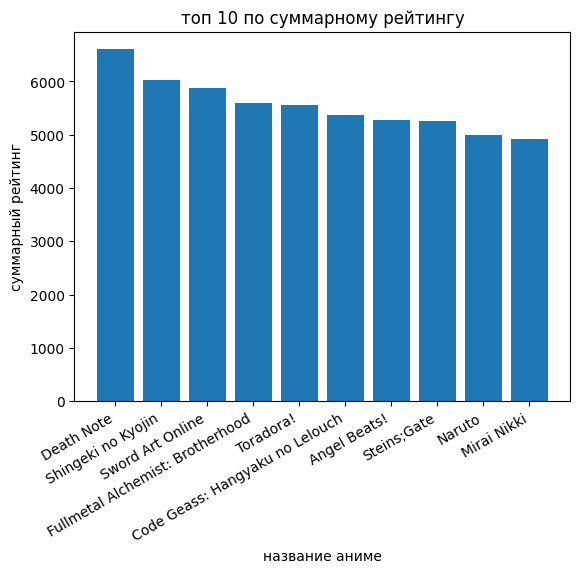

In [6]:
draw_barplor(top10_by_score.index, top10_by_score.values, 
             "топ 10 по суммарному рейтингу", "название аниме", "суммарный рейтинг")

И тут в поезде анимешников завязалась драка...

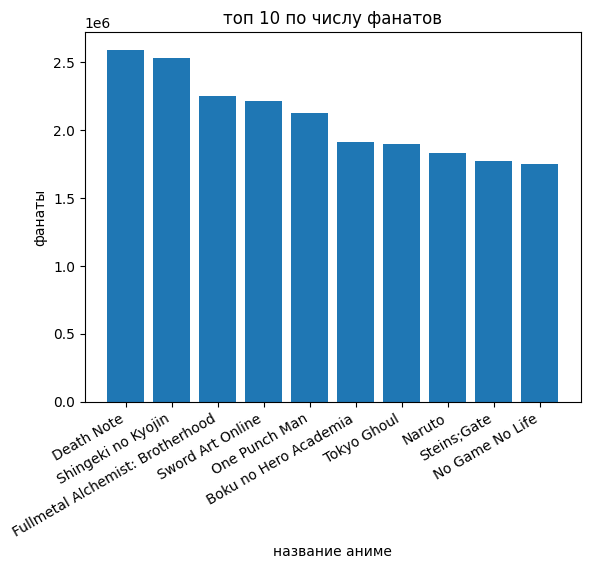

In [7]:
draw_barplor(top10_by_members['Name'], top10_by_members['Members'],
             "топ 10 по числу фанатов", "название аниме", "фанаты")

...в которую ворвались адепты Всемогущего, Сайтамы и 1000 - 7 ...

Проверим сколько в среднем поставил оценок каждый пользователь

In [8]:
count_of_users = anime_feature['user_id'].value_counts()
count_of_users.describe()

count    29569.000000
mean       101.457608
std        126.568665
min          1.000000
25%         29.000000
50%         67.000000
75%        132.000000
max       5256.000000
Name: count, dtype: float64

Половина пользователей, оцекни которых мы собираемся использовать поставили
оценки меньше чем $67$ анииме, однако средним значением для выборки является около
$101$-ой оценки. Если рассматривать, что большая часть оценок поставлена по
просмотру аниме и при этом не для каждого просмотренного аниме пользователь
поставил оценку, то для дальнейшей работы
стоит выбрать пользователей, которые поставили оцеку $75$ и более аниме. 

Данное значение было взято из следующего:
- Мной просмотрено около 300 аниме, но при этом оценка выставлена лишь половине.
- Большая часть выходящих аниме преставляют собой 12-ти серийные сериалы,
  средняя продолжительность которых составляет $12 * 24 / 60 = 4.8$ часа.
- Следовательно человек, просмотревший $75$ аниме, потратил на это $360$ часов...

$360$ часов можно интерпретировать примерно как год работы кинокритика, т.к
кроме самого просмотра, человек ещё тратит какое-то время на осмысление сюжета,
понимание мотивов героев. Если он конечно смотрит их не залпом по несколько
аниме в день из-за кошкодевочек и им подобным)

In [9]:
print(f'{type(count_of_users)}\n{count_of_users}')

<class 'pandas.core.series.Series'>
user_id
20807    5256
11100    4469
22022    4149
16869    2641
10255    2531
         ... 
3535        1
9460        1
29776       1
22912       1
31310       1
Name: count, Length: 29569, dtype: int64


In [10]:
anime_feature = anime_feature[anime_feature['user_id'].isin(count_of_users[count_of_users >= 75].index)]
anime_feature.user_id.nunique()

13688

создадим теперь таблицу, в которой строками будут названия аниме, а столбцами id пользователей. Значениями будут оценки

In [11]:
anime_pivot = anime_feature.pivot_table(index='Name', columns='user_id',
                                        values='user_score').fillna(0)
anime_pivot.head()

user_id,2,3,6,11,12,16,17,19,21,25,...,32575,32578,32582,32586,32587,32589,32591,32593,32595,32600
Name,,,,,,,,,,,,,,,,,,,,,
"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Bungaku Shoujo"" Memoire",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Bungaku Shoujo"" Movie",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


также сохраним его для дальнейшей работы, предварительно преобразовав в csr_matrix для удобства разворачивания в дальнейшем

In [12]:
cf_matrix = csr_matrix(anime_pivot.values)
save_npz(ANIME_DIR + 'cf_matrix.npz', cf_matrix)

## Коллаборативная фильтрация

In [5]:
# cf_matrix = load_npz(ANIME_DIR + 'cf_matrix.npz')
anime_pivot = pd.read_csv(ANIME_DIR + 'anime_cf.csv')

In [6]:
anime_pivot.set_index('Name', inplace= True)
anime_pivot.head()

,2,3,6,11,12,16,17,19,21,25,...,32575,32578,32582,32586,32587,32589,32591,32593,32595,32600
Name,,,,,,,,,,,,,,,,,,,,,
"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Bungaku Shoujo"" Memoire",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Bungaku Shoujo"" Movie",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
anime_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16724 entries, "0" to ◯
Columns: 13688 entries, 2 to 32600
dtypes: float64(13688)
memory usage: 1.7+ GB


In [8]:
copy_pivot = anime_pivot[random.sample(anime_pivot.columns.to_list(), 4000)]
copy_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16724 entries, "0" to ◯
Columns: 4000 entries, 9111 to 25798
dtypes: float64(4000)
memory usage: 510.5+ MB


In [9]:
cf_matrix = csr_matrix(copy_pivot.values)

In [10]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(cf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [60]:
anime_titles = copy_pivot.index

In [71]:
anime_title = np.random.choice(anime_titles)
query_index = copy_pivot.index.get_loc(anime_title)
print(f"Randomly selected anime title: {anime_title} \n")

Randomly selected anime title: Endro~! 



In [72]:
distances, index = knn_model.kneighbors(copy_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors=10)

In [74]:
print(f"Recommendations for {anime_pivot.index[query_index]}:\n")

Recommendations for Endro~!:



In [75]:
print(type(distances), distances.flatten())

<class 'numpy.ndarray'> [0.         0.73833499 0.75492671 0.76158418 0.76158418 0.78062585
 0.7867544  0.78807482 0.78807482 0.78807482]


In [76]:
print(index.flatten())

[ 3532  9333 15127 13318  2546  7110  8209  1812 14961  4004]


In [77]:
for i, ind in enumerate(index.flatten()):
    print(f'{i + 1}: {copy_pivot.index[ind]}, with distance {distances.flatten()[i]:{4}.{3}}')

1: Endro~!, with distance  0.0
2: Mini Toji, with distance 0.738
3: Tsukumogami Kashimasu, with distance 0.755
4: Shu, with distance 0.762
5: Crystal Clear, with distance 0.762
6: Kemono Friends 2, with distance 0.781
7: Leo, with distance 0.787
8: Can Can Bunny Extra, with distance 0.788
9: Tottoko Hamtarou Movie 1: Ham-Ham Land Daibouken, with distance 0.788
10: Futon, with distance 0.788


In [142]:
result = make_recomendations_with_cf(copy_pivot, count_recomendations=20)

In [161]:
if result != None:
    print(f' {20} title recomendations for {result[0]}')
    for i, value in enumerate(result[1]):
        print(f'{i + 1}: {value[0]}, with distance {value[1]:{4}.{3}}')

 20 title recomendations for Newsong
1: Wu Liuqi Zhi Zui Qiang Fa Xing Shi, with distance 0.565
2: Cike Wu Liuqi Fanwai, with distance 0.683
3: Strike the Blood III, with distance 0.739
4: Nogizaka Haruka no Himitsu: Finale, with distance 0.749
5: Ore wo Suki nano wa Omae dake ka yo: Oretachi no Game Set, with distance 0.792
6: Seitokai no Ichizon Lv.2: Watasu Seitokai, with distance 0.804
7: Shijou Saikyou no Deshi Kenichi OVA, with distance 0.816
8: Yuragi-sou no Yuuna-san OVA, with distance 0.832
9: Karakai Jouzu no Takagi-san: Water Slide, with distance 0.833
10: Macademi Wasshoi!, with distance 0.84
